In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import statistics as stat

In [570]:
df = pd.read_csv('./LIWC-22 Results - translated_text_with_other_dat___ - LIWC Analysis.csv', 
                      encoding='utf-8-sig').rename(columns={
    'gender':'Gender', 'location':'Location', 'time_1':'Time', 'gender_label':'Category'})

In [398]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
from matplotlib.pyplot import figure
import seaborn as sns

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

# Per hours regression

In [571]:
def formateTime(s):
    return s.split('/')[2]
def formateDay(s):
    return float(s.split(',')[0])
def formateHour(s):
    return float(s.split(',')[1].split(':')[0])

df['Time'] = df['Time'].apply(formateTime)
df['day'] = df['Time'].apply(formateDay)
df['hour'] = df['Time'].apply(formateHour)

In [632]:
df_clean = df[df.columns[8:]]

# remove extremly discrete values in the first few hours
X = df_clean.groupby(['day', 'hour']).mean()
X = X.reset_index()
X = X.drop(range(0,16))
y = df_clean.groupby(['day', 'hour']).size().tolist()
y = y[16:]

# Select most informative measures

In [636]:
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=mutual_info_regression, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
# vote for multiple times to find the most informative features
fs_scores = [0] * len(X.columns)

for rs in range(1, 100):
    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rs)
    # feature selection
    X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
    # add scores for the features
    for i in range(len(fs.scores_)):
#         print('Feature %d: %f %s' % (i, fs.scores_[i], fs.feature_names_in_[i]))
        fs_scores[i] += fs.scores_[i]


# plot the cumulative scores
# pyplot.figure(figsize=(24,12), dpi=300)
# pyplot.bar([i for i in range(len(fs_scores))], fs_scores)
# pyplot.xticks(np.arange(0, len(fs_scores)+1, 1))
# pyplot.show()

In [647]:
df_fScore = pd.DataFrame(columns=['index', 'feature', 'score'])
df_fScore['index'] = list(range(0, len(fs_scores)))
df_fScore['feature'] = fs.feature_names_in_
df_fScore['score'] = list(fs_scores)
ls_features = df_fScore.sort_values(by=['score'], ascending=False)[:]['feature'].tolist()

In [648]:
if ls_features[0] != 'day':
    if 'day' not in ls_features:
        ls_features.insert(0, 'day')
    else:
        ls_features.remove('day')
        ls_features.insert(0, 'day')
        
if ls_features[1] != 'hour':
    if 'hour' not in ls_features:
        ls_features.insert(1, 'hour')
    else:
        ls_features.remove('hour')
        ls_features.insert(1, 'hour')
        
dataset = X[ls_features]

In [649]:
# normalization

for name in dataset.columns[2:]: # except day and hour (positions guaranteeed)
    raw = X[name]
    dataset[name] = [float(i)/max(raw) for i in raw] # normalize to max
    
dataset['count'] = y.copy()

C:\Users\24029\AppData\Local\Temp\ipykernel_15920\56306009.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['count'] = y.copy()


0  iteration R2:  0.8043588789689939
1  iteration R2:  0.8357497224269927
2  iteration R2:  0.822238659889801
3  iteration R2:  0.8307018589114188
4  iteration R2:  0.8215461376260657
5  iteration R2:  0.8030099528661031
6  iteration R2:  0.8126201998345085
7  iteration R2:  0.8038885585616773
8  iteration R2:  0.780613907789657
9  iteration R2:  0.8078621248188264


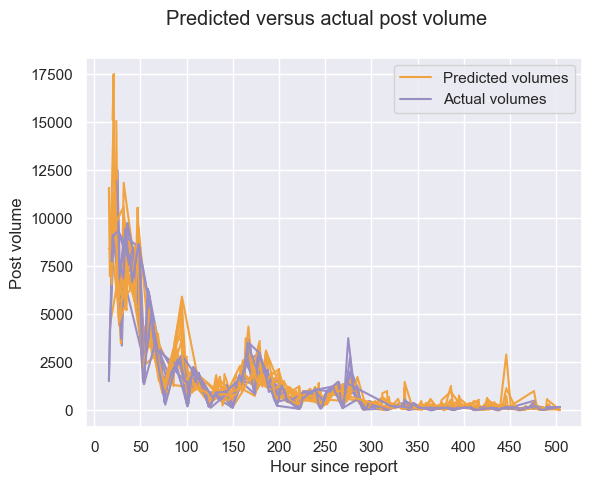

In [797]:
# run multiple times regression model and report the mean RMSE

# iteration number
n_ite = 10
# accumulater
R2s = []
MSEs = []
RMSEs = []
MAEs = []

fig = plt.figure()
fig.suptitle('Predicted versus actual post volume')
sns.set_theme()


for ite in range(n_ite):
    mask = np.random.rand(len(dataset)) < 0.8
    df_train = dataset[mask]
    # df_train = X
    df_test = dataset[~mask]
#     print('Training data set length='+str(len(df_train)))
#     print('Testing data set length='+str(len(df_test)))

    expr = "count ~ " + dataset.columns[0]
    for i in range(1, len(dataset.columns[:-1])): # except for count
        expr += ' + ' + dataset.columns[i]

    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')



    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    # print(poisson_training_results.summary())

    df_train['Lambda'] = poisson_training_results.mu
    df_train['AUX_OLS_DEP'] = df_train.apply(
        lambda x: ((x['count'] - x['Lambda'])**2 - x['Lambda']) / x['Lambda'], axis=1)
    ols_expr = """AUX_OLS_DEP ~ Lambda - 1"""
    aux_olsr_results = smf.ols(ols_expr, df_train).fit()

#     print(aux_olsr_results.params)
#     print(aux_olsr_results.tvalues) # not significant at 0.01 level but is at 0.03 level

    nb2_training_results = sm.GLM(
        y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

    # print(nb2_training_results.summary())

    nb2_predictions = nb2_training_results.get_prediction(X_test)

    predicted_counts=nb2_predictions.summary_frame()['mean']
    actual_counts = y_test['count']
    
    predicted, = plt.plot(X_test.index, predicted_counts, '-', label='Predicted volumes', marker=',', color='#f1a340')
    actual, = plt.plot(X_test.index, actual_counts, '-', label='Actual volumes', marker=',', color='#998ec3')
    
    if ite == n_ite-1: #last iteration, add legend and labels
        plt.legend(handles=[predicted, actual])

    print(ite, " iteration R2: ", nb2_training_results.pseudo_rsquared(kind='mcf'))
    R2s.append(nb2_training_results.pseudo_rsquared(kind='mcf'))
    MSEs.append(mean_squared_error(actual_counts, predicted_counts))
    RMSEs.append(math.sqrt(mean_squared_error(actual_counts, predicted_counts)))
    MAEs.append(mean_absolute_error(actual_counts, predicted_counts))

plt.xlabel("Hour since report")
plt.ylabel("Post volume")
plt.xticks(np.arange(0, 505, 50))

plt.savefig('NB2 modeling.svg')

In [805]:
print(n_ite)
print('----')

print('R2: ', stat.mean(R2s))
print('R2 sd: ', stat.stdev(R2s))
print('----')

print('RMSE: ', stat.mean(RMSEs))
print('RMSE sd: ', stat.stdev(RMSEs))
print('----')

print('MSE: ', stat.mean(MSEs))
print('MSE sd: ', stat.stdev(MSEs))
print('----')

print('MAE: ', stat.mean(MAEs))
print('MAE sd: ', stat.stdev(MAEs))
print('----')

10
----
R2:  0.8122590001694044
R2 sd:  0.016044014233464382
----
RMSE:  1027.3553579746317
RMSE sd:  220.69433280921916
----
MSE:  1099294.4212398797
MSE sd:  471281.5019685573
----
MAE:  498.18269952627344
MAE sd:  65.15814788013097
----


# Make one table

Training data set length=400
Testing data set length=89
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                  400
Model:                            GLM   Df Residuals:                      279
Model Family:                 Poisson   Df Model:                          120
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20540.
Date:                Tue, 28 Mar 2023   Deviance:                       37871.
Time:                        13:59:51   Pearson chi2:                 3.87e+04
No. Iterations:                     9   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                  400
Model:                            GLM   Df Residuals:                      279
Model Family:        NegativeBinomial   Df Model:                          120
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3325.8
Date:                Tue, 28 Mar 2023   Deviance:                       2383.1
Time:                        13:59:52   Pearson chi2:                 2.24e+03
No. Iterations:                    18   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       11.9044      1.387      8.583   

([<matplotlib.axis.XTick at 0x1ad82d0a3a0>,
 [Text(0, 0, '0'),
  Text(50, 0, '50'),
  Text(100, 0, '100'),
  Text(150, 0, '150'),
  Text(200, 0, '200'),
  Text(250, 0, '250'),
  Text(300, 0, '300'),
  Text(350, 0, '350'),
  Text(400, 0, '400'),
  Text(450, 0, '450'),
  Text(500, 0, '500')])

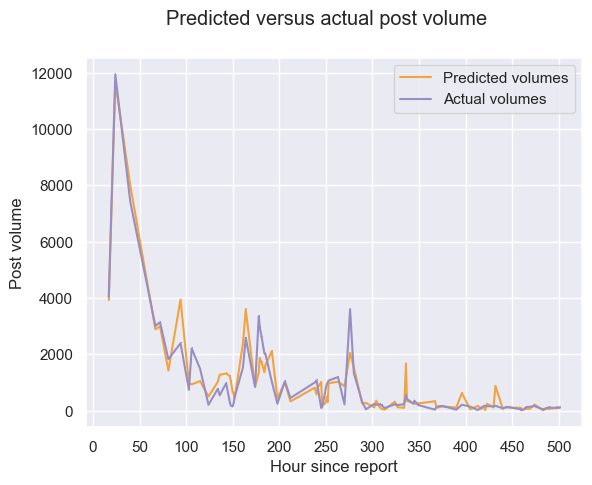

In [808]:
fig = plt.figure()
fig.suptitle('Predicted versus actual post volume')
sns.set_theme()


mask = np.random.rand(len(dataset)) < 0.8
df_train = dataset[mask]
# df_train = X
df_test = dataset[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

expr = "count ~ " + dataset.columns[0]
for i in range(1, len(dataset.columns[:-1])): # except for count
    expr += ' + ' + dataset.columns[i]

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')



poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

df_train['Lambda'] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(
    lambda x: ((x['count'] - x['Lambda'])**2 - x['Lambda']) / x['Lambda'], axis=1)
ols_expr = """AUX_OLS_DEP ~ Lambda - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

print(aux_olsr_results.params)
print(aux_olsr_results.tvalues) # not significant at 0.01 level but is at 0.03 level

nb2_training_results = sm.GLM(
    y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

print(nb2_training_results.summary())

nb2_predictions = nb2_training_results.get_prediction(X_test)

predicted_counts=nb2_predictions.summary_frame()['mean']
actual_counts = y_test['count']

predicted, = plt.plot(X_test.index, predicted_counts, '-', label='Predicted volumes', marker=',', color='#f1a340')
actual, = plt.plot(X_test.index, actual_counts, '-', label='Actual volumes', marker=',', color='#998ec3')


plt.legend(handles=[predicted, actual])
plt.xlabel("Hour since report")
plt.ylabel("Post volume")
plt.xticks(np.arange(0, 505, 50))

In [825]:
poisson_training_results.pseudo_rsquared(kind='mcf')

0.9568552464127865

In [826]:
dir(poisson_training_results)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_data_attr_model',
 '_data_in_cache',
 '_endog',
 '_freq_weights',
 '_get_robustcov_results',
 '_iweights',
 '_n_trials',
 '_use_t',
 '_var_weights',
 'aic',
 'bic',
 'bic_deviance',
 'bic_llf',
 'bse',
 'conf_int',
 'converged',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'deviance',
 'df_model',
 'df_resid',
 'f_test',
 'family',
 'fit_history',
 'fittedvalues',
 'get_hat_matrix_diag',
 'get_influence',
 'get_prediction',
 'info_criteria',
 'initialize',
 'k_constant',
 'llf',
 'llf_scaled',
 'llnull',
 'load',
 'method',
 'mle_settings',
 'model',
 'mu',
 'nobs',
 'normalized_cov_params',
 'nul

In [830]:
1-(poisson_training_results.nobs)/poisson_training_results.df_resid*(1-poisson_training_results.pseudo_rsquared(kind='mcf'))

0.938143722455608

In [809]:
nb2_training_results.pseudo_rsquared(kind='mcf')

0.8176961232126526

In [819]:
cats = nb2_training_results.pvalues.index
# sigfs = [None] * len(cats)

row=0
for i in range(0, len(nb2_training_results.pvalues)):
    if nb2_training_results.pvalues[i] < 0.001:
#         print(cats[i], ", ", '***')
        row+=1
    elif nb2_training_results.pvalues[i] < 0.01:
        row+=1
#         print(cats[i], ", ", '**')
    elif nb2_training_results.pvalues[i] < 0.05:
        row+=1
#         print(cats[i], ", ", '*')
    pass
row

82

In [824]:
import re

txt = """
Intercept       11.9044      1.387      8.583      0.000       9.186      14.623
day             -0.1790      0.007    -25.973      0.000      -0.193      -0.166
hour             0.0189      0.002     11.322      0.000       0.016       0.022
female           1.2052      0.174      6.942      0.000       0.865       1.545
Social           6.3822      1.373      4.647      0.000       3.690       9.074
socrefs         -7.6776      1.081     -7.099      0.000      -9.797      -5.558
ppron        -2627.1945    577.646     -4.548      0.000   -3759.360   -1495.029
emo_neg          4.8884      0.846      5.777      0.000       3.230       6.547
swear           -0.8373      0.267     -3.135      0.002      -1.361      -0.314
emotion         -6.7319      1.230     -5.474      0.000      -9.142      -4.321
wellness        -0.2490      0.090     -2.754      0.006      -0.426      -0.072
tone_neg       -16.4704      2.516     -6.545      0.000     -21.402     -11.538
WPS             -1.7173      0.363     -4.726      0.000      -2.430      -1.005
Exclam       -5220.5108    774.969     -6.736      0.000   -6739.421   -3701.600
relig            0.4961      0.145      3.418      0.001       0.212       0.781
risk             0.6328      0.100      6.357      0.000       0.438       0.828
socbehav        -3.7418      1.039     -3.602      0.000      -5.778      -1.706
lack             0.3792      0.162      2.346      0.019       0.062       0.696
allnone         -6.3628      1.240     -5.132      0.000      -8.793      -3.933
Affect          17.3384      2.821      6.146      0.000      11.810      22.867
home             1.1442      0.188      6.085      0.000       0.776       1.513
Analytic        -5.1589      0.782     -6.601      0.000      -6.691      -3.627
Clout            2.3183      0.448      5.176      0.000       1.440       3.196
cogproc        -11.6023      3.882     -2.989      0.003     -19.210      -3.994
time             0.6219      0.270      2.301      0.021       0.092       1.152
substances      -1.0041      0.243     -4.137      0.000      -1.480      -0.528
moral            0.3562      0.167      2.136      0.033       0.029       0.683
Drives           7.0741      3.268      2.165      0.030       0.669      13.479
tech             6.8260      1.541      4.431      0.000       3.806       9.846
fulfill         -0.6450      0.234     -2.753      0.006      -1.104      -0.186
pronoun       4951.3275   1087.915      4.551      0.000    2819.054    7083.601
auditory        -1.0679      0.372     -2.870      0.004      -1.797      -0.339
focuspresent     1.4426      0.350      4.119      0.000       0.756       2.129
i               -4.4918      1.154     -3.892      0.000      -6.754      -2.230
shehe            0.5078      0.243      2.089      0.037       0.031       0.984
focusfuture     -1.3655      0.473     -2.884      0.004      -2.293      -0.438
ipron        -2341.4477    514.472     -4.551      0.000   -3349.793   -1333.102
ethnicity       13.1777      2.678      4.921      0.000       7.930      18.426
want             2.0329      0.497      4.087      0.000       1.058       3.008
polite           0.3766      0.118      3.205      0.001       0.146       0.607
adverb          -1.5516      0.432     -3.593      0.000      -2.398      -0.705
conflict         2.5034      0.487      5.137      0.000       1.548       3.459
visual          -1.1329      0.323     -3.509      0.000      -1.766      -0.500
Authentic        2.0350      0.552      3.684      0.000       0.952       3.118
tentat           1.4192      0.333      4.264      0.000       0.767       2.072
money            4.1076      0.777      5.285      0.000       2.584       5.631
emo_sad         -0.3843      0.186     -2.064      0.039      -0.749      -0.019
OtherP       -2165.0841    321.297     -6.739      0.000   -2794.814   -1535.354
AllPunc       8659.0960   1285.098      6.738      0.000    6140.351    1.12e+04
male            -1.1550      0.192     -6.028      0.000      -1.531      -0.779
prep             2.1731      0.611      3.554      0.000       0.975       3.371
Lifestyle       -4.5363      1.202     -3.774      0.000      -6.892      -2.181
Linguistic      -8.7390      3.749     -2.331      0.020     -16.087      -1.391
Cognition       15.6324      4.453      3.511      0.000       6.905      24.360
emo_pos          5.5027      1.161      4.739      0.000       3.227       7.779
QMark        -3900.4852    578.993     -6.737      0.000   -5035.292   -2765.679
acquire         -1.0791      0.291     -3.712      0.000      -1.649      -0.509
BigWords        -1.8057      0.383     -4.716      0.000      -2.556      -1.055
Comma        -1775.5816    263.744     -6.732      0.000   -2292.510   -1258.653
verb             2.7979      1.350      2.073      0.038       0.153       5.443
affiliation     -5.9014      1.560     -3.784      0.000      -8.958      -2.845
tone_pos        -8.0387      1.390     -5.783      0.000     -10.763      -5.314
politic         11.2685      2.261      4.983      0.000       6.837      15.700
health           2.1506      0.270      7.958      0.000       1.621       2.680
work             3.6163      0.702      5.151      0.000       2.240       4.992
reward          -2.7576      0.197    -14.017      0.000      -3.143      -2.372
Culture        -17.9836      3.696     -4.866      0.000     -25.227     -10.740
Apostro      -1336.7762    198.043     -6.750      0.000   -1724.934    -948.618
illness         -1.8288      0.170    -10.747      0.000      -2.162      -1.495
food            -0.4744      0.177     -2.674      0.007      -0.822      -0.127
we               1.5439      0.212      7.294      0.000       1.129       1.959
Period       -4213.1888    625.221     -6.739      0.000   -5438.600   -2987.778
cause            0.8147      0.198      4.114      0.000       0.427       1.203
comm            -0.5719      0.190     -3.016      0.003      -0.944      -0.200
Tone             1.9402      0.412      4.706      0.000       1.132       2.748
leisure          1.7144      0.354      4.840      0.000       1.020       2.409
feeling         -0.9440      0.317     -2.978      0.003      -1.565      -0.323
conj             2.0498      0.379      5.406      0.000       1.307       2.793
focuspast       -0.8314      0.182     -4.571      0.000      -1.188      -0.475
negate           1.3925      0.438      3.179      0.001       0.534       2.251
quantity         0.8040      0.223      3.603      0.000       0.367       1.241
family           0.4798      0.145      3.317      0.001       0.196       0.763
"""
txt = re.sub(r' {2,}', ',', txt)
print(txt)


Intercept,11.9044,1.387,8.583,0.000,9.186,14.623
day,-0.1790,0.007,-25.973,0.000,-0.193,-0.166
hour,0.0189,0.002,11.322,0.000,0.016,0.022
female,1.2052,0.174,6.942,0.000,0.865,1.545
Social,6.3822,1.373,4.647,0.000,3.690,9.074
socrefs,-7.6776,1.081,-7.099,0.000,-9.797,-5.558
ppron,-2627.1945,577.646,-4.548,0.000,-3759.360,-1495.029
emo_neg,4.8884,0.846,5.777,0.000,3.230,6.547
swear,-0.8373,0.267,-3.135,0.002,-1.361,-0.314
emotion,-6.7319,1.230,-5.474,0.000,-9.142,-4.321
wellness,-0.2490,0.090,-2.754,0.006,-0.426,-0.072
tone_neg,-16.4704,2.516,-6.545,0.000,-21.402,-11.538
WPS,-1.7173,0.363,-4.726,0.000,-2.430,-1.005
Exclam,-5220.5108,774.969,-6.736,0.000,-6739.421,-3701.600
relig,0.4961,0.145,3.418,0.001,0.212,0.781
risk,0.6328,0.100,6.357,0.000,0.438,0.828
socbehav,-3.7418,1.039,-3.602,0.000,-5.778,-1.706
lack,0.3792,0.162,2.346,0.019,0.062,0.696
allnone,-6.3628,1.240,-5.132,0.000,-8.793,-3.933
Affect,17.3384,2.821,6.146,0.000,11.810,22.867
home,1.1442,0.188,6.085,0.000,0.776,1.513
Ana